# Introduction

In this project, a neural network is used to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
# !pip install --upgrade ipywidgets

# # Shutdown notebook and then restart after doing this

# # Do not run this cell again

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import time
from tqdm import tqdm

import os

In [3]:
# Set a random seed for reproducibility
torch.manual_seed(0)

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).


In [4]:
# Define the mean and standard deviation values
mean = 0.1307
std = 0.3081


data_transform = transforms.Compose([transforms.ToTensor(),   # Convert PIL Image to Tensor
                                     transforms.Normalize((mean,), (std)),
                                     transforms.Lambda(lambda x: x.view(x.shape[0], -1).squeeze())  # Flattening operation
                                    ])
# Load the MNIST  training data dataset
data = datasets.MNIST(root = 'data', download = True, train = True, transform = data_transform)

# Spliting the training data into training and validation dataset using 80:20
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

# Create training set and define training dataloader
train_data, val_data = random_split(data, [train_size, val_size], generator=torch.Generator().manual_seed(0))

# Load the MNIST training dataset
test_data = datasets.MNIST(root ='data', download = True, train = False, transform = data_transform)

# Create a data loader for test, train and validation dataset

train_loader = DataLoader(train_data, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_data, batch_size = 64, shuffle=False)

## NOTES:

## Note: I specified on a single mean and variance because the MNIST has only one color channel.
## Note: If the dataset used is an RGB image, specify 3.


# Define transforms to normalise data

## Note: No need to rotate, crop, or flip as the dataset
## Note: In a fully-connected network, the input to each layer must be 1-D.
##       However, The MNIST dataset images are 28 * 28 2D tensors, so we need to convert them into 1-D vectors.
##       This conversion is done by flattening. I could either do this in the data preprocessing or in my model



100%|██████████| 9912422/9912422 [00:00<00:00, 79809939.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49809084.63it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23876058.65it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15901943.88it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(f"Training data: {len(train_data)} images / {len(train_loader)} batches")
print(f"Testing data: {len(test_data)} images / {len(test_loader)} batches")
print(f"Validation data: {len(val_data)} images / {len(val_loader)} batches")

Training data: 48000 images / 750 batches
Testing data: 10000 images / 157 batches
Validation data: 12000 images / 188 batches


In [6]:
# Confirm flattening was done correctly.
dataiter = iter(train_loader)
images,labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 784])
torch.Size([64])


## Justifying preprocessing methods


- Normalization was performed to scale the pixel values. I specified a single mean and variance for `normalization` because the `MNIST` has only one color channel.

-  In a fully-connected network, the input to each layer must be 1-D. However, The MNIST dataset images are 28 * 28 2D tensors, so we need to convert them into 1-D vectors. This conversion is done by flattening. I could either do this in the data preprocessing or in my model

- I didn't crop, rotate, flip or perform other transformations because the image are already centered and aligned, and the digits occupy most of the image frame.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.

In [7]:
def show5(img_loader):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # Display 5 images
    num_images = 5
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {labels[i]}")

    plt.show()

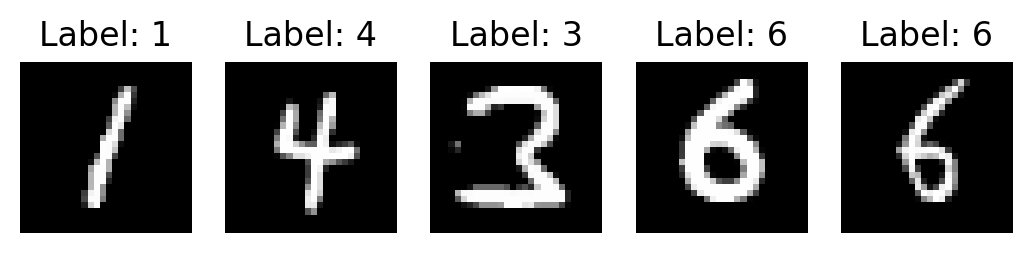

In [8]:
# Explore data
show5(val_loader)

In [9]:
## This cell contains a function for showing 5 images from a dataloader
def show_5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        #image = images[i].numpy()   # use if images haven't been flattened
        image = images.numpy().reshape(-1,28)  #Reshape flattened image to its original shape
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


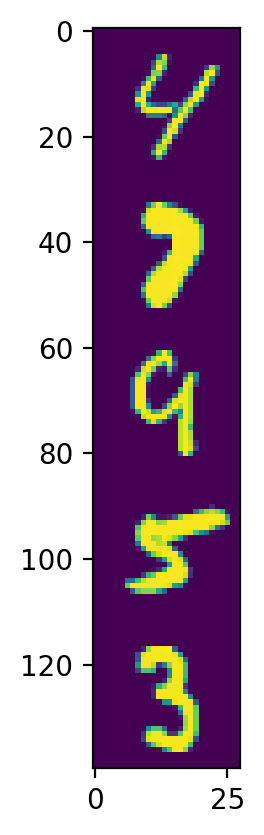

7


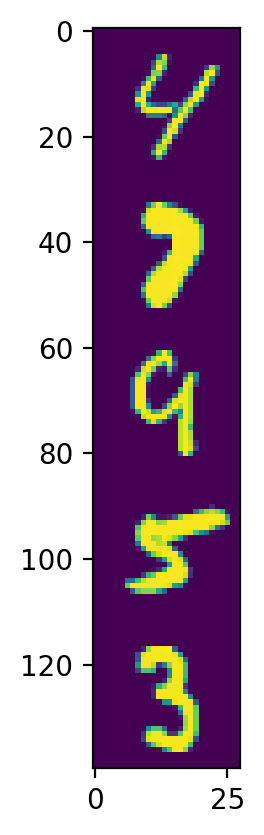

9


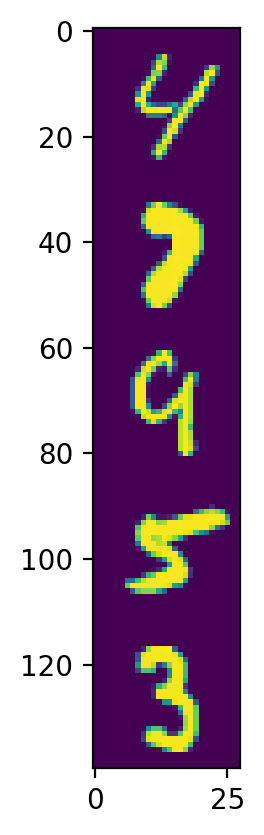

5


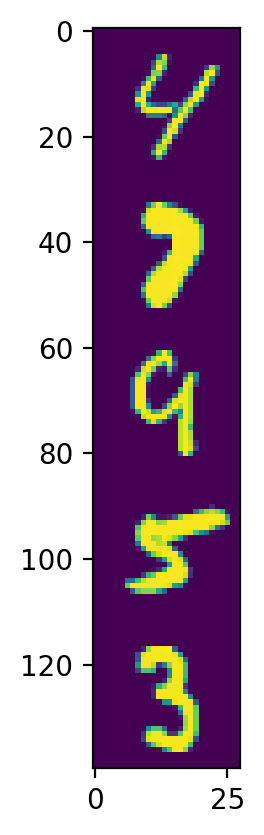

3


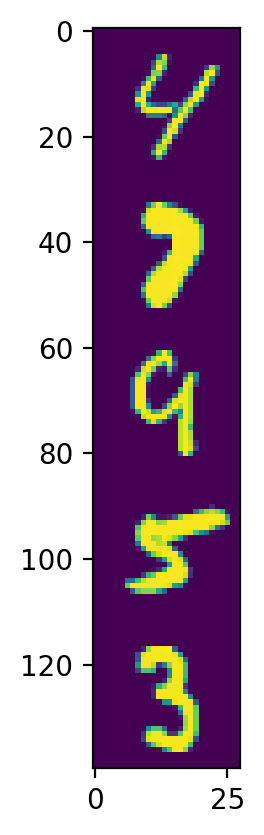

In [10]:
show_5(val_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [11]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [256, 64]  #[256, 128, 64]
output_size = 10


In [12]:
class MNIST_model(nn.Module):
    def __init__(self, dropout_p = 0.0):
        super().__init__()
        #self.dropout_p = dropout_p

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        #self.output = nn.Linear(hidden_sizes[2], output_size)
        self.output = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(p = dropout_p)

        # Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self,x):
        # x = torch.flatten(x,1) # Use this if tensor wasn't flattened in the transforms.

        x = self.dropout(torch.sigmoid(self.fc1(x)))
        x = self.dropout(torch.sigmoid(self.fc2(x)))
        #x = self.dropout(torch.sigmoid(self.fc3(x)))

        # Output can't be dropped out
        x = F.log_softmax(self.output(x), dim = 1)

        return x


## Use if no dropout
#         x = F.sigmoid(self.fc1(x))
#         x = F.sigmoid(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
#         x = F.log_softmax(self.output(x))


In [87]:
# create the network and it's text representation
model = MNIST_model(dropout_p = 0.3)

Specify a loss function and an optimizer, and instantiate the model.

In [88]:
criterion = nn.NLLLoss()  # Loss function defined

optimizer = optim.Adam(model.parameters(), lr = 0.0007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00)

## Running the Neural Network

In [89]:
def training_network(net, train_loader, val_loader, epochs=None, threshold=None, patience=None):
    """
    Train a network using the specified parameters.

    Args:
        net (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        epochs (int or None, optional): The number of training epochs. I
                                        If not provided (None), default = 10 will be used.
        threshold (float or None, optional): The threshold for early stopping based on the validation loss improvement. 
                                             If not provided (None), default = 0.001.
        patience (int or None, optional): The patience value for early stopping. 
                                          If not provided (None), default value 3 will be used. 

    Returns:
        tuple: A tuple containing the validation losses, training losses, training accuracy, 
               validation accuracy and number of epochs.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    if epochs is None:
        epochs = 10

    # # Criterion assignment logic
    # if criterion is not None:
    #     criterion = criterion   # Use the provided criterion
    # else:
    #     criterion = nn.NLLLoss()  # Use the default criterion nn.NLLLoss()

    # if learning_rate is not None:
    #   adjust_learning_rate(optimizer, learning_rate)

    training_losses, validation_losses = [], []

    training_accuracy, validation_accuracy = [], []

    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    below_threshold_counter = 0  # Counter to keep track of non-improving epochs

    if patience is None:
        patience = 3  # Default value for patience

    if threshold is None:
        threshold = 0.001  # Default value for threshold difference

    start_time = time.time()  # Start time

    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0

        # Training Loop
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = net(inputs)
            loss = criterion(preds, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds_train = torch.exp(preds)  # converts log probabilities
            _, preds_train = torch.max(preds_train.data, dim=1)
            train_correct += torch.sum(preds_train == labels).item()

        val_loss = 0.0
        val_correct = 0

        net.eval()  # Turns off dropout and sets model to evaluation and inference mode.

        with torch.no_grad(): # turns off gradient descent. No need for param update as we are not traning
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs) # Values are log probabilities
                loss = criterion(outputs,labels)

                val_loss += loss.item()  # Accumulate the loss

                preds = torch.exp(outputs) # converts log probabilities
                _, preds = torch.max(preds.data, dim =1)
                val_correct += torch.sum(preds == labels).item()


        # Get mean loss for training and validation
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        # Obtain train accuracy
        train_accuracy = train_correct/len(train_loader.dataset)

        # Obtain the accuracy at the completion of the epochs.
        # The fraction of the correct predictions in the test data
        accuracy = val_correct/len(val_loader.dataset)

        validation_losses.append(val_loss)
        training_losses.append(train_loss)

        training_accuracy.append(train_accuracy)
        validation_accuracy.append(accuracy)


        print(f"Epoch: {epoch+1}/{epochs}..",
              f"Training Loss: {train_loss:.3f}.. ",
              f"Training Accuracy:{train_accuracy * 100:.3f}.. ",
              f"Validation Loss: {val_loss:.3f}.. ",
              f"Validation Accuracy: {accuracy * 100:.3f}")


        # Check if validation loss improves by the threshold or not
        if best_val_loss - val_loss > threshold:
            best_val_loss = val_loss
            below_threshold_counter = 0  # Reset the counter
        else:
            below_threshold_counter += 1  # Increment the counter

            # Check if the counter reaches the patience limit
            if below_threshold_counter >= patience:
                print(f"Validation loss did not improve by the threshold for {patience} epochs. Early stopping.")
                break  # Stop training

        net.train() # set the model to training

    end_time = time.time()  # End time
    total_time = end_time - start_time

    print("\n** Total Elapsed Runtime:",
              str(int((total_time/3600)))+":"+str(int((total_time%3600)/60))+":"
              +str(int((total_time%3600)%60)) )

    return validation_losses, training_losses,  training_accuracy, validation_accuracy,epochs

In [90]:
# Training the model
validation_losses, training_losses, training_accuracy, validation_accuracy, epochs = \
    training_network(model, train_loader, val_loader, epochs = 13)

100%|██████████| 188/188 [00:05<00:00, 34.09it/s]


Epoch: 1/13.. Training Loss: 0.809..  Training Accuracy:79.806..  Validation Loss: 0.300..  Validation Accuracy: 92.108


100%|██████████| 188/188 [00:04<00:00, 43.00it/s]


Epoch: 2/13.. Training Loss: 0.300..  Training Accuracy:91.977..  Validation Loss: 0.208..  Validation Accuracy: 94.142


100%|██████████| 188/188 [00:04<00:00, 43.44it/s]


Epoch: 3/13.. Training Loss: 0.222..  Training Accuracy:93.921..  Validation Loss: 0.168..  Validation Accuracy: 95.033


100%|██████████| 188/188 [00:04<00:00, 43.85it/s]


Epoch: 4/13.. Training Loss: 0.182..  Training Accuracy:94.929..  Validation Loss: 0.136..  Validation Accuracy: 95.950


100%|██████████| 188/188 [00:04<00:00, 41.34it/s]


Epoch: 5/13.. Training Loss: 0.153..  Training Accuracy:95.717..  Validation Loss: 0.124..  Validation Accuracy: 96.283


100%|██████████| 188/188 [00:04<00:00, 40.20it/s]


Epoch: 6/13.. Training Loss: 0.134..  Training Accuracy:96.183..  Validation Loss: 0.110..  Validation Accuracy: 96.633


100%|██████████| 188/188 [00:05<00:00, 33.88it/s]


Epoch: 7/13.. Training Loss: 0.120..  Training Accuracy:96.504..  Validation Loss: 0.102..  Validation Accuracy: 96.933


100%|██████████| 188/188 [00:04<00:00, 37.97it/s]


Epoch: 8/13.. Training Loss: 0.107..  Training Accuracy:96.958..  Validation Loss: 0.097..  Validation Accuracy: 97.117


100%|██████████| 188/188 [00:04<00:00, 43.71it/s]


Epoch: 9/13.. Training Loss: 0.100..  Training Accuracy:97.062..  Validation Loss: 0.096..  Validation Accuracy: 97.167


100%|██████████| 188/188 [00:04<00:00, 43.39it/s]


Epoch: 10/13.. Training Loss: 0.090..  Training Accuracy:97.317..  Validation Loss: 0.089..  Validation Accuracy: 97.458


100%|██████████| 188/188 [00:04<00:00, 45.70it/s]


Epoch: 11/13.. Training Loss: 0.083..  Training Accuracy:97.590..  Validation Loss: 0.085..  Validation Accuracy: 97.575


100%|██████████| 188/188 [00:07<00:00, 26.08it/s]


Epoch: 12/13.. Training Loss: 0.076..  Training Accuracy:97.754..  Validation Loss: 0.086..  Validation Accuracy: 97.375


100%|██████████| 188/188 [00:05<00:00, 35.37it/s]

Epoch: 13/13.. Training Loss: 0.070..  Training Accuracy:97.846..  Validation Loss: 0.086..  Validation Accuracy: 97.383

** Total Elapsed Runtime: 0:5:54


Plot the training loss (and validation loss/accuracy, if recorded).

In [48]:
def plot_training_and_validation(training_metrics, validation_metrics, metric_name):
    """ Plots the training and validation metrics over epochs
    
    Args:
        training_metrics (list): A list of training metric values for each epoch.
        validation_metrics (list): A list of validation metric values for each epoch.
        metric_name (str): name of metric being plotted
    
    
    """
    epochs = len(training_metrics)  # Get the number of epochs based on the length of training_metrics

    x_ticks = range(1, epochs + 1, 5)  # Show ticks at every 5 epochs
    x_labels = [str(i) for i in x_ticks]  # Convert tick values to string labels

    plt.plot(training_metrics, label='Training {}'.format(metric_name))
    plt.plot(validation_metrics, label='Validation {}'.format(metric_name))

    plt.xticks(x_ticks, x_labels)
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.title("Training and Validation {}".format(metric_name))
    plt.legend(frameon=False)

    plt.show()

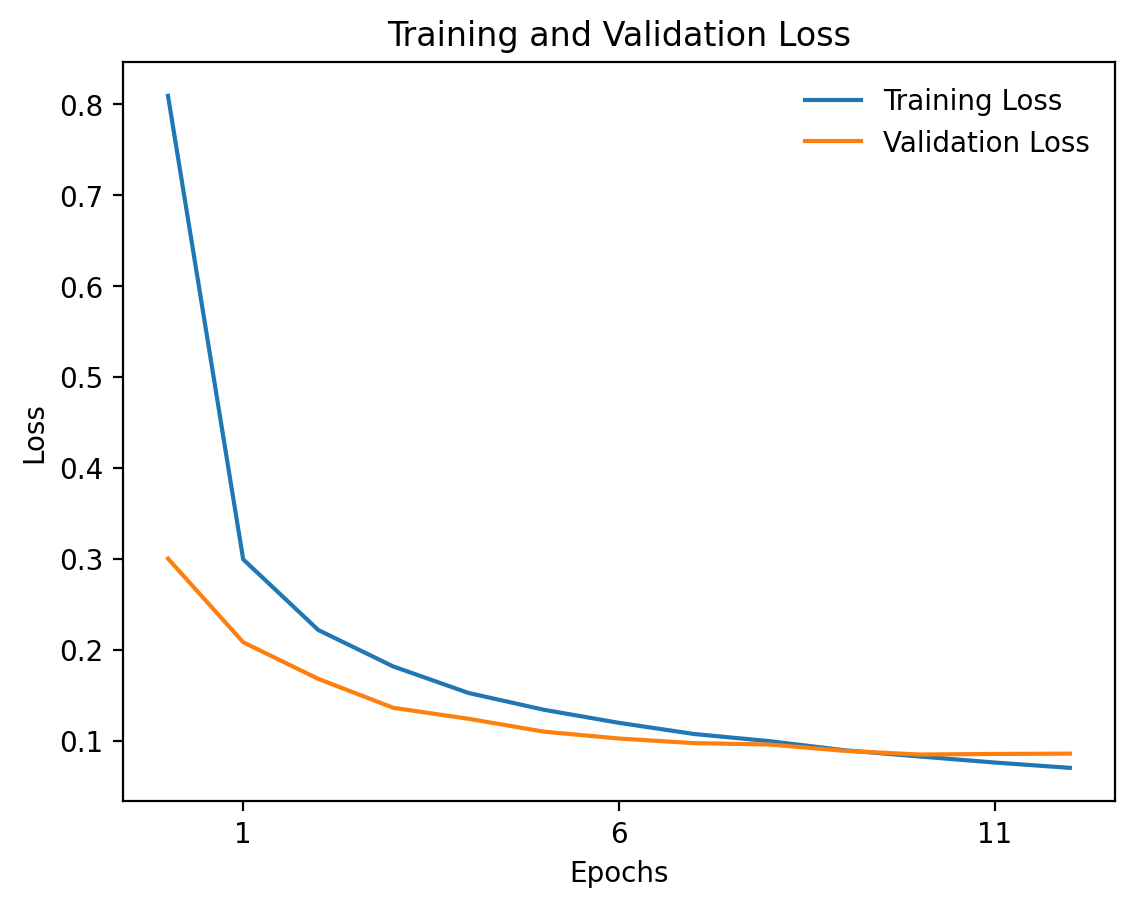

In [91]:
# Plot losses
plot_training_and_validation(training_losses, validation_losses, "Loss")

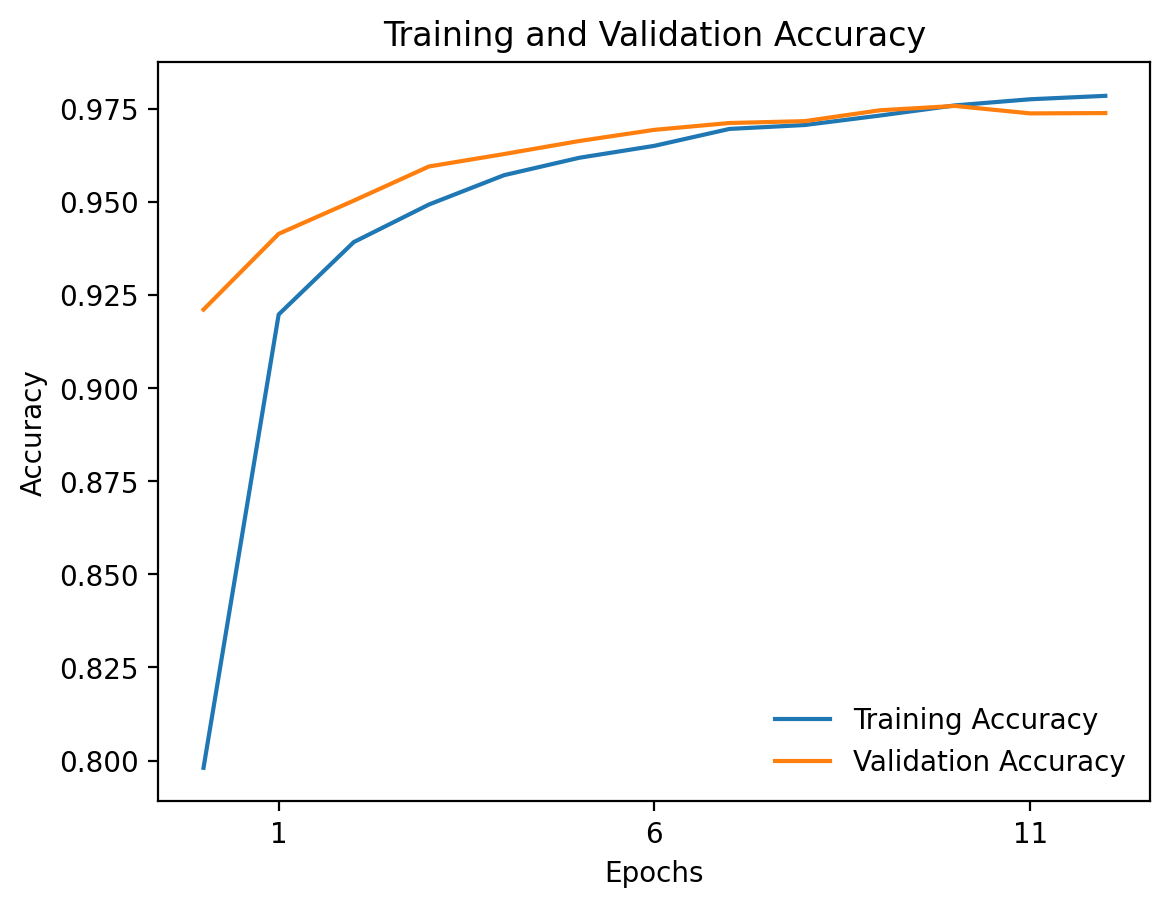

In [92]:
plot_training_and_validation(training_accuracy, validation_accuracy, "Accuracy")

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.


In [21]:
def testing_network(net,data_loader):
    """ Test a network using specified model and DataLoader
    
    Args:
        net (torch.nn.Module): The neural network model to test
        data_loader (torch.utils.data.DataLoader): DataLoader for the testing dataset.
        
    Returns: 
        None
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs) # Values are log probabilities
            loss = criterion(outputs,labels)

            test_loss += loss.item()  # Accumulate the loss

            preds = torch.exp(outputs) # converts log probabilities
            _, preds = torch.max(preds.data, dim = 1)
            test_correct += torch.sum(preds == labels).item()

        # Get mean loss for test data
        test_loss = test_loss / len(data_loader)

        # Obtain the accuracy at the completion of the epochs.
        # The fraction of the correct predictions in the test data
        accuracy = test_correct/len(data_loader.dataset)

        print(f"Testing Loss: {test_loss:.3f}.. ",
              f"Test Accuracy: {accuracy * 100:.3f}")

    return None



In [93]:
# testing the model on the test dataset
testing_network(model, test_loader)

100%|██████████| 157/157 [00:03<00:00, 43.44it/s]

Testing Loss: 0.124..  Test Accuracy: 96.400


# Observation

After multiple iterations and hyperparameter tuning, I observed that the model consistently starts to show signs of overfitting around `epoch 10`. Therefore, it is advisable to stop the training at this point during hyperparameter tuning to prevent further degradation in performance or train again by tuning the hyperparamters.

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [40]:
# Creating an instance of the model with dropout probability of 0.5
model_hyper_tune = MNIST_model(dropout_p = 0.5)

# Creating an Adam optimizer
optimizer = optim.Adam(model_hyper_tune.parameters(), lr = 0.0005, betas=(0.96, 0.999), eps=1e-08, weight_decay=0.00)

In [41]:
# Training the model

validation_losses, training_losses, training_accuracy, validation_accuracy, epochs \
                 = training_network(model_hyper_tune, train_loader, val_loader, epochs=35,threshold=None, patience=None)

100%|██████████| 188/188 [00:04<00:00, 43.50it/s]


Epoch: 1/35.. Training Loss: 1.167..  Training Accuracy:68.321..  Validation Loss: 0.460..  Validation Accuracy: 89.667


100%|██████████| 188/188 [00:04<00:00, 43.59it/s]


Epoch: 2/35.. Training Loss: 0.493..  Training Accuracy:87.508..  Validation Loss: 0.289..  Validation Accuracy: 92.167


100%|██████████| 188/188 [00:04<00:00, 42.92it/s]


Epoch: 3/35.. Training Loss: 0.377..  Training Accuracy:90.227..  Validation Loss: 0.237..  Validation Accuracy: 93.250


100%|██████████| 188/188 [00:04<00:00, 43.30it/s]


Epoch: 4/35.. Training Loss: 0.319..  Training Accuracy:91.550..  Validation Loss: 0.208..  Validation Accuracy: 94.033


100%|██████████| 188/188 [00:04<00:00, 42.74it/s]


Epoch: 5/35.. Training Loss: 0.286..  Training Accuracy:92.302..  Validation Loss: 0.184..  Validation Accuracy: 94.533


100%|██████████| 188/188 [00:04<00:00, 43.01it/s]


Epoch: 6/35.. Training Loss: 0.257..  Training Accuracy:93.075..  Validation Loss: 0.164..  Validation Accuracy: 95.133


100%|██████████| 188/188 [00:05<00:00, 37.21it/s]


Epoch: 7/35.. Training Loss: 0.233..  Training Accuracy:93.717..  Validation Loss: 0.154..  Validation Accuracy: 95.483


100%|██████████| 188/188 [00:04<00:00, 41.86it/s]


Epoch: 8/35.. Training Loss: 0.219..  Training Accuracy:94.154..  Validation Loss: 0.143..  Validation Accuracy: 95.675


100%|██████████| 188/188 [00:04<00:00, 42.91it/s]


Epoch: 9/35.. Training Loss: 0.203..  Training Accuracy:94.467..  Validation Loss: 0.132..  Validation Accuracy: 96.000


100%|██████████| 188/188 [00:05<00:00, 37.10it/s]


Epoch: 10/35.. Training Loss: 0.193..  Training Accuracy:94.823..  Validation Loss: 0.128..  Validation Accuracy: 96.133


100%|██████████| 188/188 [00:05<00:00, 36.25it/s]


Epoch: 11/35.. Training Loss: 0.183..  Training Accuracy:94.996..  Validation Loss: 0.118..  Validation Accuracy: 96.433


100%|██████████| 188/188 [00:04<00:00, 37.61it/s]


Epoch: 12/35.. Training Loss: 0.169..  Training Accuracy:95.296..  Validation Loss: 0.119..  Validation Accuracy: 96.450


100%|██████████| 188/188 [00:05<00:00, 32.41it/s]


Epoch: 13/35.. Training Loss: 0.165..  Training Accuracy:95.458..  Validation Loss: 0.113..  Validation Accuracy: 96.667


100%|██████████| 188/188 [00:05<00:00, 35.14it/s]


Epoch: 14/35.. Training Loss: 0.160..  Training Accuracy:95.565..  Validation Loss: 0.110..  Validation Accuracy: 96.633


100%|██████████| 188/188 [00:05<00:00, 37.31it/s]


Epoch: 15/35.. Training Loss: 0.156..  Training Accuracy:95.721..  Validation Loss: 0.107..  Validation Accuracy: 96.900


100%|██████████| 188/188 [00:05<00:00, 35.52it/s]


Epoch: 16/35.. Training Loss: 0.146..  Training Accuracy:95.894..  Validation Loss: 0.103..  Validation Accuracy: 96.983


100%|██████████| 188/188 [00:05<00:00, 37.47it/s]


Epoch: 17/35.. Training Loss: 0.140..  Training Accuracy:95.944..  Validation Loss: 0.099..  Validation Accuracy: 97.167


100%|██████████| 188/188 [00:04<00:00, 40.29it/s]


Epoch: 18/35.. Training Loss: 0.137..  Training Accuracy:96.154..  Validation Loss: 0.098..  Validation Accuracy: 97.083


100%|██████████| 188/188 [00:04<00:00, 39.44it/s]


Epoch: 19/35.. Training Loss: 0.135..  Training Accuracy:96.131..  Validation Loss: 0.097..  Validation Accuracy: 97.108


100%|██████████| 188/188 [00:04<00:00, 41.01it/s]


Epoch: 20/35.. Training Loss: 0.127..  Training Accuracy:96.450..  Validation Loss: 0.092..  Validation Accuracy: 97.308


100%|██████████| 188/188 [00:04<00:00, 45.93it/s]


Epoch: 21/35.. Training Loss: 0.126..  Training Accuracy:96.448..  Validation Loss: 0.094..  Validation Accuracy: 97.150


100%|██████████| 188/188 [00:05<00:00, 37.02it/s]


Epoch: 22/35.. Training Loss: 0.121..  Training Accuracy:96.506..  Validation Loss: 0.093..  Validation Accuracy: 97.267


100%|██████████| 188/188 [00:07<00:00, 25.60it/s]


Epoch: 23/35.. Training Loss: 0.121..  Training Accuracy:96.508..  Validation Loss: 0.089..  Validation Accuracy: 97.392


100%|██████████| 188/188 [00:04<00:00, 44.83it/s]


Epoch: 24/35.. Training Loss: 0.116..  Training Accuracy:96.677..  Validation Loss: 0.090..  Validation Accuracy: 97.417


100%|██████████| 188/188 [00:04<00:00, 44.05it/s]


Epoch: 25/35.. Training Loss: 0.111..  Training Accuracy:96.794..  Validation Loss: 0.090..  Validation Accuracy: 97.350


100%|██████████| 188/188 [00:04<00:00, 44.06it/s]

Epoch: 26/35.. Training Loss: 0.108..  Training Accuracy:96.854..  Validation Loss: 0.088..  Validation Accuracy: 97.417
Validation loss did not improve by the threshold for 3 epochs. Early stopping.

** Total Elapsed Runtime: 0:12:6


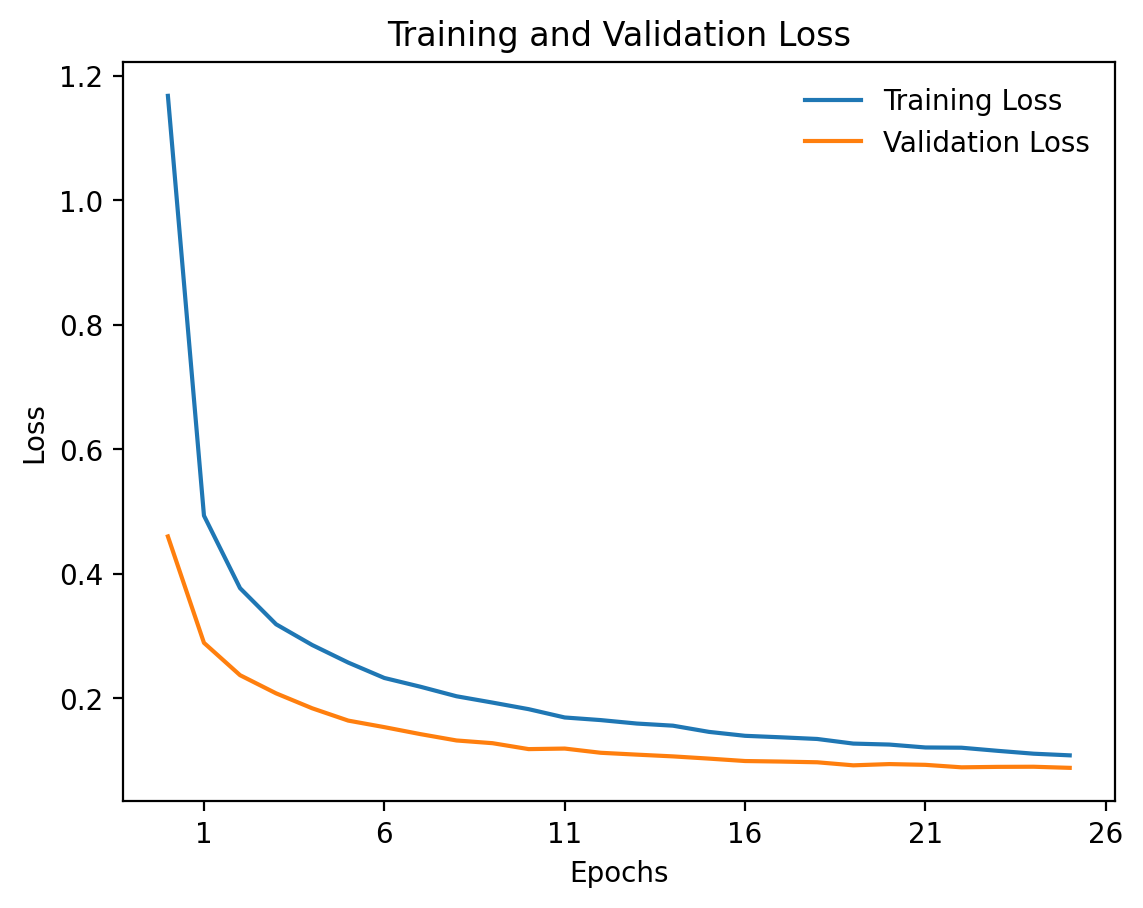

In [49]:
# Plot losses
plot_training_and_validation(training_losses, validation_losses, "Loss")

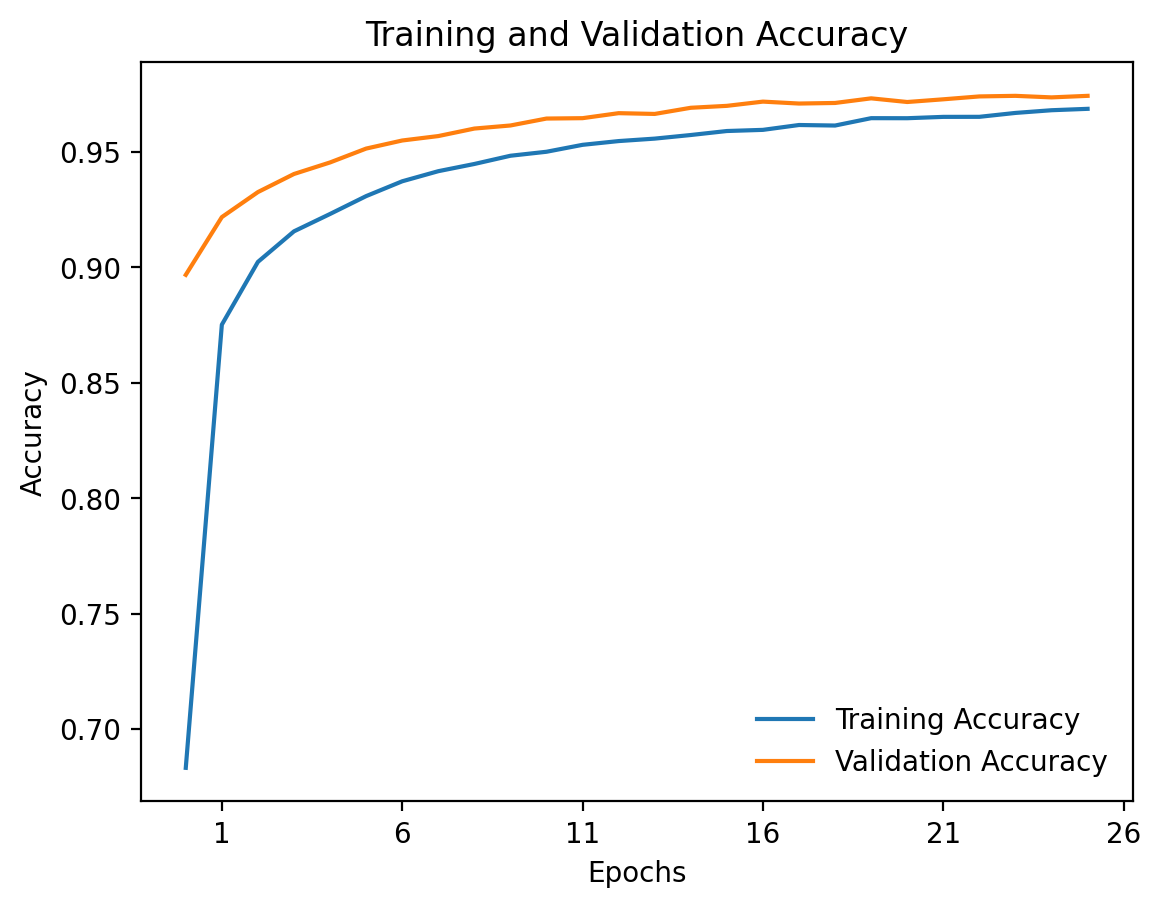

In [50]:
# Plot Accuracy
plot_training_and_validation(training_accuracy, validation_accuracy, "Accuracy")

In [51]:
# testing the trained network on the test dataset
testing_network(model_hyper_tune,test_loader)

100%|██████████| 157/157 [00:03<00:00, 43.29it/s]

Testing Loss: 0.083..  Test Accuracy: 97.490


## Saving your model
Using `torch.save`, save your model for future loading.

In [52]:
def get_hidden_out_features(model):
    """
    Returns the number of output features for all hidden layers in the model.

    Args:
        - model (nn.Module): model to get hidden layer output features from

    Returns:
        - list of integers representing the number of output features for all hidden layers in the model
    """
    hidden_features = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and name.startswith('fc'):
            hidden_features.append(module.out_features)
    return hidden_features

In [53]:
get_hidden_out_features(model_hyper_tune)

[256, 64]

In [54]:
def save_checkpoint(model, optimizer, epochs, checkpoint_path = ''):

    """ Save the state of a trained model, optimizer
    Args:
        model (nn.Module): trained model to save
        epochs (int): number of epochs trained
        optimizer (torch.optim.Optimizer): optimizer used for training
        checkpoint_path (str): directory where the checkpoint fill will be saved (default: current directory)
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Retrieve the model's architecture name, input features, and output size
    arch = type(model).__name__
    input_features = model.fc1.in_features
    output_size = model.output.out_features

    checkpoint = {
        'arch': arch,
        'epoch': epochs,
        'input_features': model_hyper_tune.fc1.in_features,
        'output': output_size,
        'hidden_layers': get_hidden_out_features(model),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),

    }

    # If the model is on the GPU, move the checkpoint to the CPU
    if device.type == 'cuda':
        # Move the model to the CPU
        model.to('cpu')

        # Use a dictionary comprehension to move any tensors in the checkpoint to the CPU
        checkpoint = {k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in checkpoint.items()}

    # Set the file path for saving the checkpoint
    if checkpoint_path:
      os.makedirs(checkpoint_path, exist_ok=True)
      checkpoint_file = os.path.join(checkpoint_path, 'checkpoint.pth')

    else:
      checkpoint_path = 'checkpoint.pth'  #if path isn't specified. Save in work directory

    # Save the checkpoint to a file
    torch.save(checkpoint, checkpoint_path)

In [55]:
# save checkpoint
save_checkpoint(model_hyper_tune, optimizer, epochs, checkpoint_path = '')


In [56]:
# from google.colab import drive
# drive.mount('/content/drive')


# import shutil

# # Define the paths of the source file in Colab and the destination folder in Drive
# source_file = '/content/checkpoint.pth'
# destination_folder = '/content/drive/MyDrive/MNIST_2'

# # Copy the file from Colab to Drive
# shutil.copy(source_file, destination_folder)


Mounted at /content/drive


'/content/drive/MyDrive/MNIST_2/checkpoint.pth'

In [59]:
# load saved checkpoint
torch.load('checkpoint.pth')

{'arch': 'MNIST_model',
 'epoch': 35,
 'input_features': 784,
 'output': 10,
 'hidden_layers': [256, 64],
 'model_state_dict': OrderedDict([('fc1.weight',
               tensor([[ 0.0402,  0.0403,  0.0538,  ...,  0.0746,  0.0335,  0.0593],
                       [ 0.0274,  0.0812,  0.0685,  ...,  0.0336,  0.0416,  0.0317],
                       [-0.0096,  0.0249,  0.0503,  ...,  0.0363,  0.0460,  0.0528],
                       ...,
                       [ 0.0463,  0.0293,  0.0410,  ...,  0.0718,  0.0643,  0.0162],
                       [ 0.0605,  0.0232,  0.0008,  ...,  0.0056, -0.0066,  0.0401],
                       [ 0.0653,  0.0538,  0.0054,  ...,  0.0247,  0.0089,  0.0011]])),
              ('fc1.bias',
               tensor([-5.7686e-02, -2.2210e-02,  9.6836e-03,  1.2479e-02, -1.0771e-01,
                       -6.1493e-02, -1.2763e-02, -2.1534e-02, -2.3934e-02, -6.1765e-02,
                        7.5871e-02, -5.6544e-02,  5.9920e-02, -7.5627e-03,  1.5564e-02,
             